# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN 

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc

import joblib

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# magic word for producing visualizations in notebook
%matplotlib inline

# Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Data Exploration & Visualization

In [2]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\luisc\anaconda3\envs\HOML_env\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
azdias.shape, customers.shape

((891221, 366), (191652, 369))

### General Population

In [5]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [7]:
azdias.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 366 columns):
 #    Column                       Non-Null Count   Dtype  
---   ------                       --------------   -----  
 0    LNR                          891221 non-null  int64  
 1    AGER_TYP                     891221 non-null  int64  
 2    AKT_DAT_KL                   817722 non-null  float64
 3    ALTER_HH                     817722 non-null  float64
 4    ALTER_KIND1                  81058 non-null   float64
 5    ALTER_KIND2                  29499 non-null   float64
 6    ALTER_KIND3                  6170 non-null    float64
 7    ALTER_KIND4                  1205 non-null    float64
 8    ALTERSKATEGORIE_FEIN         628274 non-null  float64
 9    ANZ_HAUSHALTE_AKTIV          798073 non-null  float64
 10   ANZ_HH_TITEL                 794213 non-null  float64
 11   ANZ_KINDER                   817722 non-null  float64
 12   ANZ_PERSONEN                 817722 non-nu

In [8]:
azdias.isnull().sum().to_frame('nulls').sort_values('nulls', ascending=False)

,nulls
ALTER_KIND4,890016
ALTER_KIND3,885051
ALTER_KIND2,861722
ALTER_KIND1,810163
EXTSEL992,654153
...,...
D19_VERSAND_ANZ_24,0
D19_VERSAND_DATUM,0
D19_VERSAND_OFFLINE_DATUM,0
D19_VERSAND_ONLINE_DATUM,0


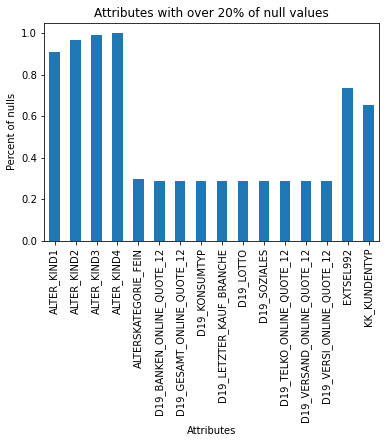

In [14]:
azdias_nulls = pd.Series(azdias.isnull().sum() / len(azdias))
ax = azdias_nulls[azdias_nulls > .2].plot(kind='bar')
ax.set_xlabel('Attributes')
ax.set_ylabel('Percent of nulls')
ax.set_title('Attributes with over 20% of null values');

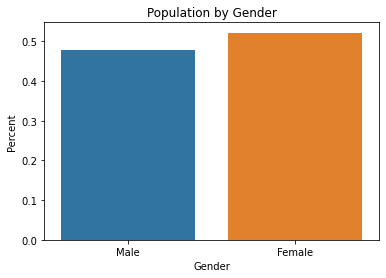

In [10]:
ax = sns.barplot(x=['Male', 'Female'], y=azdias['ANREDE_KZ'].value_counts(normalize=True).sort_index())
ax.set_xlabel('Gender')
ax.set_ylabel('Percent')
ax.set_title('Population by Gender');

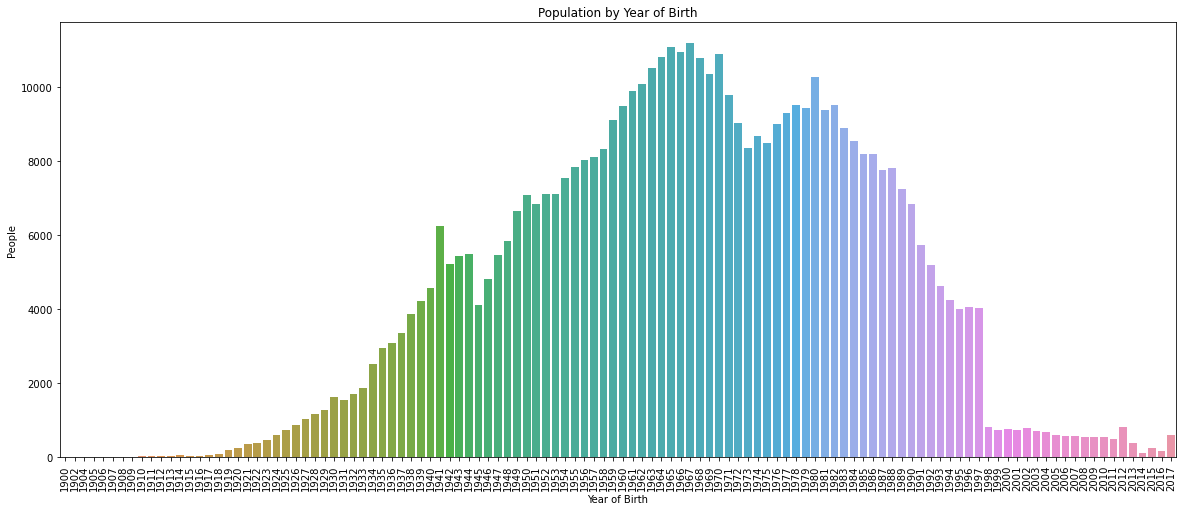

In [11]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x=azdias[['GEBURTSJAHR']].query('GEBURTSJAHR != 0')['GEBURTSJAHR'].value_counts().sort_index().index, 
                 y=azdias[['GEBURTSJAHR']].query('GEBURTSJAHR != 0')['GEBURTSJAHR'].value_counts().sort_index())
plt.xticks(rotation=90)
ax.set_xlabel('Year of Birth')
ax.set_ylabel('People')
ax.set_title('Population by Year of Birth');

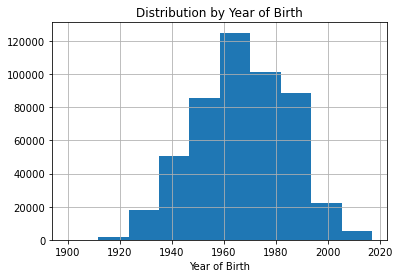

In [12]:
ax = azdias[['GEBURTSJAHR']].query('GEBURTSJAHR != 0')['GEBURTSJAHR'].hist()
ax.set_xlabel('Year of Birth')
ax.set_title('Distribution by Year of Birth');

### Customers

In [15]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [16]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [17]:
customers.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 369 columns):
 #    Column                       Non-Null Count   Dtype  
---   ------                       --------------   -----  
 0    LNR                          191652 non-null  int64  
 1    AGER_TYP                     191652 non-null  int64  
 2    AKT_DAT_KL                   145056 non-null  float64
 3    ALTER_HH                     145056 non-null  float64
 4    ALTER_KIND1                  11766 non-null   float64
 5    ALTER_KIND2                  5100 non-null    float64
 6    ALTER_KIND3                  1275 non-null    float64
 7    ALTER_KIND4                  236 non-null     float64
 8    ALTERSKATEGORIE_FEIN         139810 non-null  float64
 9    ANZ_HAUSHALTE_AKTIV          141725 non-null  float64
 10   ANZ_HH_TITEL                 139542 non-null  float64
 11   ANZ_KINDER                   145056 non-null  float64
 12   ANZ_PERSONEN                 145056 non-nu

In [18]:
customers.isnull().sum().to_frame('nulls').sort_values('nulls', ascending=False)

,nulls
ALTER_KIND4,191416
ALTER_KIND3,190377
ALTER_KIND2,186552
ALTER_KIND1,179886
KK_KUNDENTYP,111937
...,...
D19_VERSAND_ANZ_24,0
D19_VERSAND_DATUM,0
D19_VERSAND_OFFLINE_DATUM,0
D19_VERSAND_ONLINE_DATUM,0


In [19]:
customers_nulls = pd.Series(customers.isnull().sum() / len(customers))

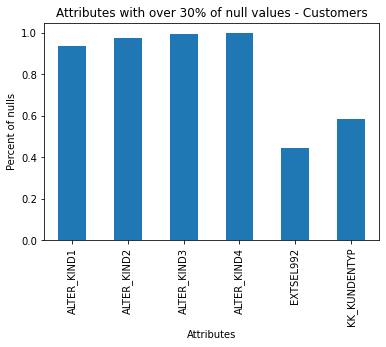

In [24]:
ax = customers_nulls[customers_nulls > .30].plot(kind='bar')
ax.set_xlabel('Attributes')
ax.set_ylabel('Percent of nulls')
ax.set_title('Attributes with over 30% of null values - Customers');

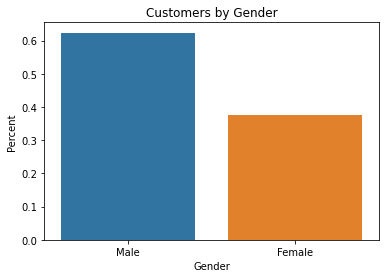

In [25]:
ax = sns.barplot(x=['Male', 'Female'], y=customers['ANREDE_KZ'].value_counts(normalize=True).sort_index())
ax.set_xlabel('Gender')
ax.set_ylabel('Percent')
ax.set_title('Customers by Gender');

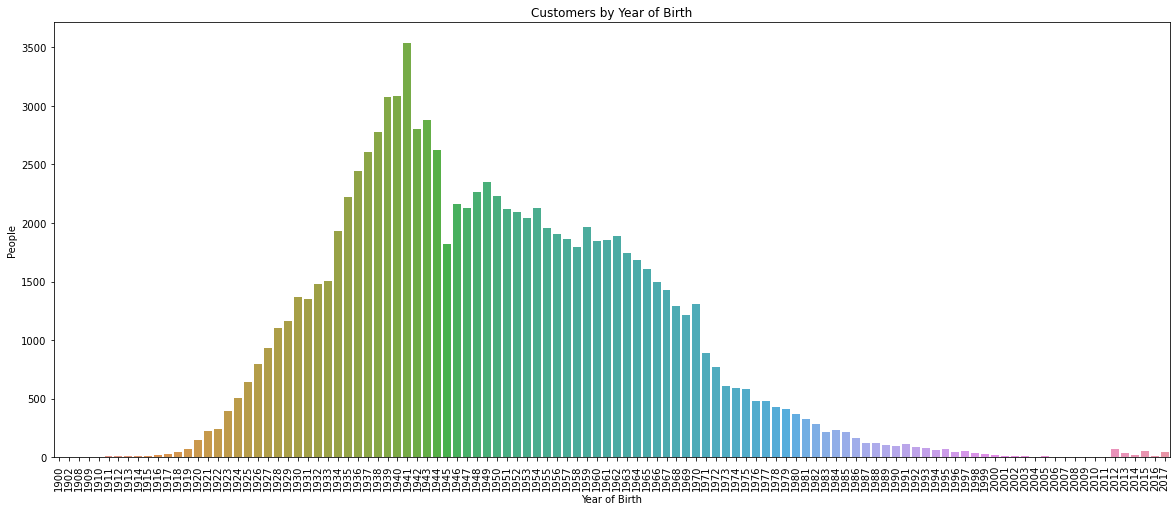

In [26]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x=customers[['GEBURTSJAHR']].query('GEBURTSJAHR != 0')['GEBURTSJAHR'].value_counts().sort_index().index, 
                 y=customers[['GEBURTSJAHR']].query('GEBURTSJAHR != 0')['GEBURTSJAHR'].value_counts().sort_index())
plt.xticks(rotation=90)
ax.set_xlabel('Year of Birth')
ax.set_ylabel('People')
ax.set_title('Customers by Year of Birth');

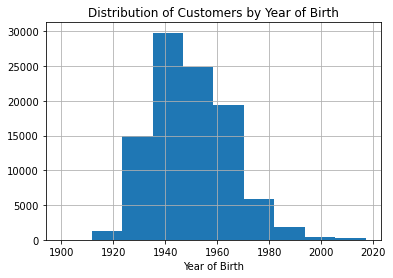

In [27]:
ax = customers[['GEBURTSJAHR']].query('GEBURTSJAHR != 0')['GEBURTSJAHR'].hist()
ax.set_xlabel('Year of Birth')
ax.set_title('Distribution of Customers by Year of Birth');

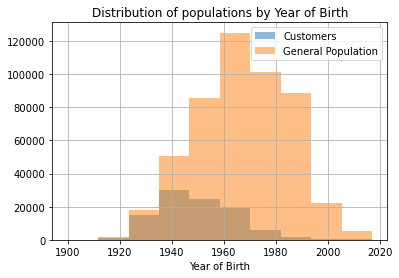

In [28]:
ax = customers[['GEBURTSJAHR']].query('GEBURTSJAHR != 0')['GEBURTSJAHR'].hist(alpha=0.5, label='Customers')
ax = azdias[['GEBURTSJAHR']].query('GEBURTSJAHR != 0')['GEBURTSJAHR'].hist(alpha=0.5, label='General Population')
ax.set_xlabel('Year of Birth')
ax.set_title('Distribution of populations by Year of Birth')
plt.legend(loc='upper right');

C:\Users\luisc\anaconda3\envs\HOML_env\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\luisc\anaconda3\envs\HOML_env\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


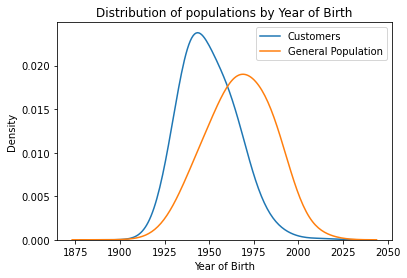

In [29]:
ax = sns.kdeplot(customers[['GEBURTSJAHR']].query('GEBURTSJAHR != 0')['GEBURTSJAHR'], bw=0.5, label='Customers')
ax = sns.kdeplot(azdias[['GEBURTSJAHR']].query('GEBURTSJAHR != 0')['GEBURTSJAHR'], bw=0.5, label='General Population')

ax.set_xlabel('Year of Birth')
ax.set_title('Distribution of populations by Year of Birth')
plt.legend(loc='upper right');

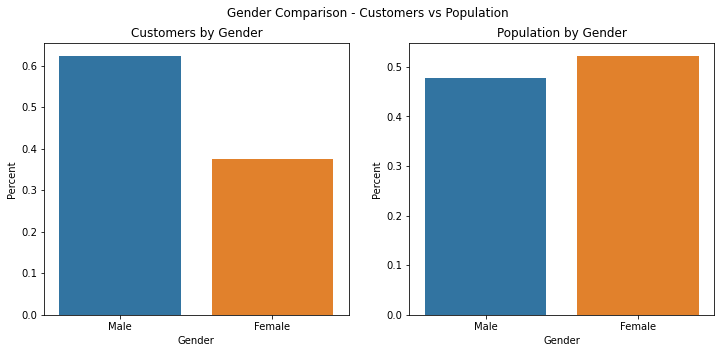

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Gender Comparison - Customers vs Population')


sns.barplot(x=['Male', 'Female'], y=customers['ANREDE_KZ'].value_counts(normalize=True).sort_index(), ax=axs[0] )
axs[0].set_title("Customers by Gender")
axs[0].set_xlabel('Gender')
axs[0].set_ylabel('Percent')

sns.barplot(x=['Male', 'Female'], y=azdias['ANREDE_KZ'].value_counts(normalize=True).sort_index(), ax=axs[1])
axs[1].set_title("Population by Gender")
axs[1].set_xlabel('Gender')
axs[1].set_ylabel('Percent');

# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Data Preprocessing

In [3]:
# Read Excels spreadsheet info to detect nulls coded as -1, 0, etc.
data_dict = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1, usecols='B:E')
data_dict = data_dict.fillna(method='ffill')
unknowns = data_dict.query('Meaning == "unknown"')
unknowns['Value'] = unknowns['Value'].astype(str)
unknowns['Value'] = unknowns['Value'].str.split(',')
unknowns = unknowns[['Attribute', 'Value']]

C:\Users\luisc\AppData\Local\Temp/ipykernel_19996/2905121678.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknowns['Value'] = unknowns['Value'].astype(str)
C:\Users\luisc\AppData\Local\Temp/ipykernel_19996/2905121678.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknowns['Value'] = unknowns['Value'].str.split(',')


In [4]:
def data_prep(df_, unknowns=unknowns):
    """Cleans, encodes, and scales population or customer data, returns array X

    Args:
        df_: Dataframe with population or customer data provided by Arvato.
        unknowns: Dataframe with columns and corresponding value for unknown data.
    Returns:
        df: A clean and encoded pandas DataFrame.

    """
    
    df = df_.copy()
    
    for attribute, value in zip(unknowns.Attribute, unknowns.Value):
        value = [x.strip() for x in value]
        value = value + [float(x) for x in value]
        try:
            df.loc[df[attribute].isin(value), attribute] = np.nan
        except:
            pass
        
    #azdias_nulls = pd.Series(azdias.isnull().sum() / len(azdias))
    #azdias_nulls[azdias_nulls > .20].plot(kind='bar')
    #cols_to_drop = azdias_nulls[azdias_nulls > .20].index
    # Cols with over 20% nulls from general pop:
    cols_to_drop = ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_BAUMAX',
       'KK_KUNDENTYP', 'TITEL_KZ']
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    # Drop rows with over 10 nulls
    df = df[df.isnull().sum(axis=1) < 10]
    
    df.drop('EINGEFUEGT_AM', axis=1, inplace=True)
    df['CAMEO_DEUG_2015'] = pd.to_numeric(df['CAMEO_DEUG_2015'], errors='coerce')
    df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'], errors='coerce')

    for col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    df_cat = df.select_dtypes(exclude=[np.number])
    df.drop(df_cat.columns, axis=1, inplace=True)
    
    df = pd.concat([df, pd.get_dummies(df_cat)], axis=1)
    
    if 'CAMEO_DEU_2015_XX' in df.columns:
        df.drop(['CAMEO_DEU_2015_XX'], axis=1, inplace=True)    
    
    return df

In [5]:
# Retain only columns in general pop
customers = customers[azdias.columns]

In [6]:
# Prep population data
pop_df = data_prep(azdias)
scaler = StandardScaler()

X_pop = scaler.fit_transform(pop_df)

In [66]:
# Prep customers data
customers_df = data_prep(customers)

X_customers = scaler.transform(customers_df)

In [67]:
pop_df.shape

(732198, 391)

In [68]:
customers_df.shape

(131177, 391)

## Implementation
### Principal Component Analysis

In [158]:
# Apply PCA - 100 to find optimum number
pca = PCA(n_components=100)
X_pop_reduced = pca.fit_transform(X_pop)

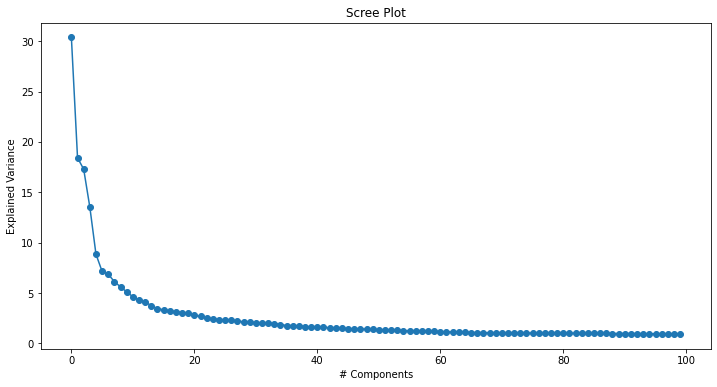

In [166]:
plt.figure(figsize=(12, 6))
plt.plot(pca.explained_variance_[:100], marker='o')
plt.xlabel("# Components")
plt.ylabel("Explained Variance")
plt.title("Scree Plot");

In [69]:
# Apply PCA again, just pick 40 components based on graph
pca = PCA(n_components=40)
X_pop_reduced = pca.fit_transform(X_pop)
X_cust_reduced = pca.transform(X_customers)

In [70]:
X_pop_reduced.shape, azdias.shape

((732198, 40), (891221, 366))

In [71]:
X_cust_reduced.shape, customers.shape

((131177, 40), (191652, 366))

### KMeans Clusters

In [57]:
# 30 clusters try
inertia_list = []
for k in range(1, 31):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(X_pop_reduced)
    inertia_list.append(kmeans.inertia_)

Text(0.5, 1.0, 'Inertia per Number of Clusters')

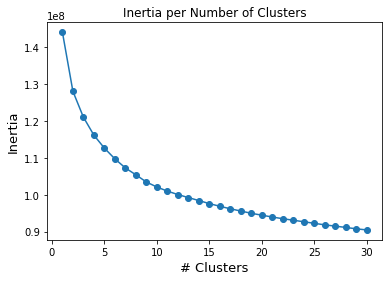

In [50]:
# Plot KMeans inertia to pick best k value
plt.plot(range(1, 31), inertia_list)
plt.scatter(range(1, 31), inertia_list)
plt.xlabel("# Clusters", size=13)
plt.ylabel("Inertia", size=13)
plt.title("Inertia per Number of Clusters", size=12)

In [72]:
# Pick 20 as appropiate number of clusters based on chart
k = 20
kmeans = KMeans(n_clusters=k)
labels_population = kmeans.fit_predict(X_pop_reduced)

In [73]:
# Apply clusters on customers
labels_customers = kmeans.predict(X_cust_reduced)

## Results: Customer Segmentation Analysis

In [74]:
# Add labels to df
pop_df['CLUSTER'] = labels_population
customers_df['CLUSTER'] = labels_customers

In [75]:
cluster_percent = pd.DataFrame(pop_df['CLUSTER'].value_counts(normalize=True).sort_index())
cluster_percent['POPULATION'] = 'General'

In [76]:
# Get percentage of population based on clusters
cluster_percent = pd.concat([cluster_percent,
                             pd.DataFrame(customers_df['CLUSTER'].value_counts(normalize=True).sort_index())])\
                            .fillna('Customers')

In [77]:
cluster_percent.reset_index(inplace=True)
cluster_percent.columns = ['CLUSTER', 'PERCENTAGE', 'POPULATION']

In [78]:
cluster_percent['PERCENTAGE'] = round(cluster_percent['PERCENTAGE']*100, 2)

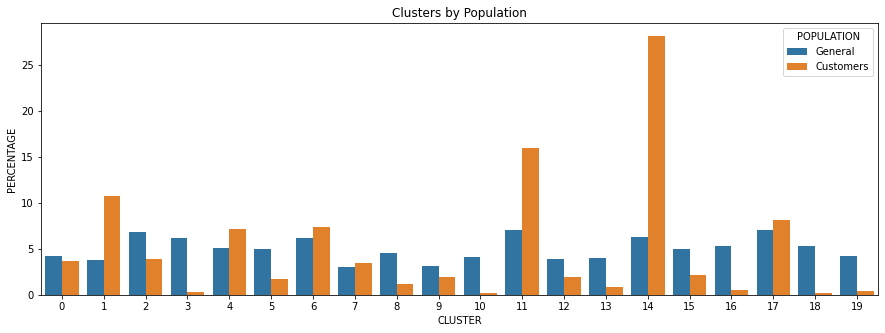

In [79]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x="CLUSTER", y='PERCENTAGE', hue="POPULATION", data=cluster_percent)
ax.set_title('Clusters by Population');

In [80]:
cluster_percent_pivot = pd.pivot(cluster_percent, index='CLUSTER', columns='POPULATION', values='PERCENTAGE')
cluster_percent_pivot['Difference'] = cluster_percent_pivot['Customers'] - cluster_percent_pivot['General']

In [81]:
# Clusters Overrepresented with customers
cluster_percent_pivot.sort_values('Difference', ascending=False).head(3)

POPULATION,Customers,General,Difference
CLUSTER,,,
14,28.12,6.29,21.83
11,15.92,7.09,8.83
1,10.69,3.80,6.89


In [84]:
# Clusters Underrepresented with customers
cluster_percent_pivot.sort_values('Difference', ascending=False).tail(3)

POPULATION,Customers,General,Difference
CLUSTER,,,
16,0.52,5.25,-4.73
18,0.20,5.26,-5.06
3,0.31,6.19,-5.88


### Results - Underrepresented with customers

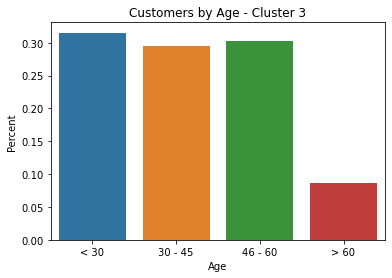

In [102]:
# Age
age_classes = ["< 30",
"30 - 45",
"46 - 60",
"> 60",
"uniformly dist."]

ax = sns.barplot(x=age_classes[:-1], y=customers_df.query('CLUSTER == 3')['ALTERSKATEGORIE_GROB'].value_counts(normalize=True).sort_index())
ax.set_xlabel('Age')
ax.set_ylabel('Percent')
ax.set_title('Customers by Age - Cluster 3');

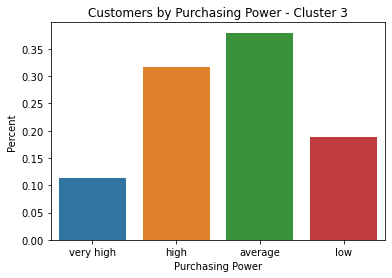

In [90]:
# Purchasing Power
purchasing_power_classes = ["very high", "high", "average", "low"]

ax = sns.barplot(x=purchasing_power_classes,
                 y=customers_df.query('CLUSTER == 3')['KKK'].value_counts(normalize=True).sort_index())
ax.set_xlabel('Purchasing Power')
ax.set_ylabel('Percent')
ax.set_title('Customers by Purchasing Power - Cluster 3');

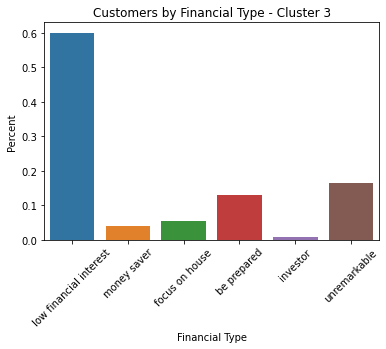

In [91]:
# Financial Type

financial_types = ["low financial interest", "money saver", "focus on house", "be prepared", "investor", "unremarkable"]
ax = sns.barplot(x=financial_types,
                 y=customers_df.query('CLUSTER == 3')['FINANZTYP'].value_counts(normalize=True).sort_index())
ax.set_xlabel('Financial Type')
ax.set_ylabel('Percent')
ax.set_title('Customers by Financial Type - Cluster 3')
plt.xticks(rotation=45);

### Results - Overrepresented in customers

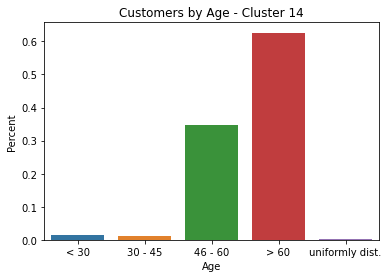

In [101]:
# Age
ax = sns.barplot(x=age_classes, y=customers_df.query('CLUSTER == 14')['ALTERSKATEGORIE_GROB'].value_counts(normalize=True).sort_index())
ax.set_xlabel('Age')
ax.set_ylabel('Percent')
ax.set_title('Customers by Age - Cluster 14');

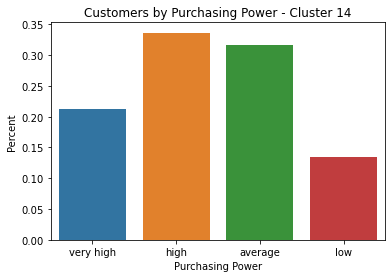

In [97]:
# Purchasing Power
ax = sns.barplot(x=purchasing_power_classes,
                 y=customers_df.query('CLUSTER == 14')['KKK'].value_counts(normalize=True).sort_index())
ax.set_xlabel('Purchasing Power')
ax.set_ylabel('Percent')
ax.set_title('Customers by Purchasing Power - Cluster 14');

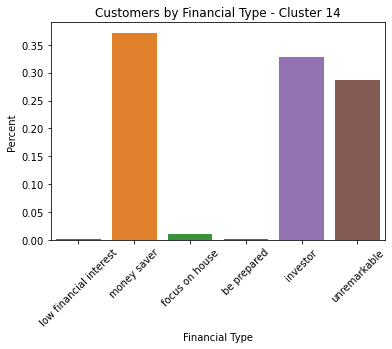

In [99]:
# Financial Type

ax = sns.barplot(x=financial_types,
                 y=customers_df.query('CLUSTER == 14')['FINANZTYP'].value_counts(normalize=True).sort_index())
ax.set_xlabel('Financial Type')
ax.set_ylabel('Percent')
ax.set_title('Customers by Financial Type - Cluster 14')
plt.xticks(rotation=45);

# Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

## Data Exploration and Visualization

In [7]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
#mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\luisc\anaconda3\envs\HOML_env\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [209]:
mailout_train.shape

(42962, 367)

In [8]:
train_set, test_set = train_test_split(mailout_train, test_size=0.2, stratify=mailout_train['RESPONSE'], random_state=42)

In [107]:
train_set.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
25923,36580,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,7.0,4.0,2.0,5.0,8.0,7.0,1,0,2,4
14938,24424,1,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,1.0,1.0,2.0,9.0,4.0,4,0,2,4
1928,19946,2,1.0,13.0,NaN,NaN,NaN,NaN,6.0,1.0,...,1.0,1.0,1.0,4.0,9.0,3.0,3,0,1,4
20513,31541,2,1.0,12.0,NaN,NaN,NaN,NaN,12.0,12.0,...,9.0,7.0,4.0,6.0,9.0,5.0,3,0,2,4
2325,20427,-1,1.0,13.0,NaN,NaN,NaN,NaN,0.0,1.0,...,1.0,2.0,1.0,6.0,9.0,7.0,1,0,2,4


In [108]:
train_set.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,34369.000000,34369.000000,28836.000000,28836.000000,1598.000000,606.000000,138.000000,33.000000,27875.000000,28193.000000,...,28596.000000,28596.000000,28596.000000,26662.000000,28836.000000,28193.000000,34369.000000,34369.000000,34369.000000,34369.000000
mean,42783.842853,0.543979,1.532494,10.267548,12.538798,13.701320,14.536232,14.181818,9.841937,6.726953,...,4.333333,4.521332,3.127011,4.489011,8.729158,4.066470,2.808548,0.012395,1.595740,3.217493
std,24775.310459,1.412276,1.753636,6.077640,3.914641,3.078837,2.688606,3.320905,4.382095,15.068085,...,3.171370,3.288569,2.534633,1.886251,1.013088,2.048308,1.125326,0.110642,0.490755,1.063636
min,5.000000,-1.000000,1.000000,0.000000,2.000000,5.000000,6.000000,6.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,21286.000000,-1.000000,1.000000,8.000000,9.000000,12.000000,13.000000,13.000000,8.000000,1.000000,...,1.000000,2.000000,1.000000,3.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
50%,42819.000000,1.000000,1.000000,10.000000,13.000000,14.000000,15.000000,15.000000,10.000000,2.000000,...,4.000000,4.000000,2.000000,6.000000,9.000000,3.000000,3.000000,0.000000,2.000000,4.000000
75%,64189.000000,2.000000,1.000000,15.000000,16.000000,16.000000,17.000000,17.000000,13.000000,7.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,7.000000,3.000000,0.000000,2.000000,4.000000
max,85795.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,353.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [109]:
train_set.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34369 entries, 25923 to 4668
Data columns (total 367 columns):
 #    Column                       Non-Null Count  Dtype  
---   ------                       --------------  -----  
 0    LNR                          34369 non-null  int64  
 1    AGER_TYP                     34369 non-null  int64  
 2    AKT_DAT_KL                   28836 non-null  float64
 3    ALTER_HH                     28836 non-null  float64
 4    ALTER_KIND1                  1598 non-null   float64
 5    ALTER_KIND2                  606 non-null    float64
 6    ALTER_KIND3                  138 non-null    float64
 7    ALTER_KIND4                  33 non-null     float64
 8    ALTERSKATEGORIE_FEIN         27875 non-null  float64
 9    ANZ_HAUSHALTE_AKTIV          28193 non-null  float64
 10   ANZ_HH_TITEL                 27815 non-null  float64
 11   ANZ_KINDER                   28836 non-null  float64
 12   ANZ_PERSONEN                 28836 non-null  float64
 1

In [110]:
train_set.isnull().sum().to_frame('nulls').sort_values('nulls', ascending=False)

,nulls
ALTER_KIND4,34336
ALTER_KIND3,34231
ALTER_KIND2,33763
ALTER_KIND1,32771
KK_KUNDENTYP,20216
...,...
D19_VERSAND_ANZ_24,0
D19_VERSAND_DATUM,0
D19_VERSAND_OFFLINE_DATUM,0
D19_VERSAND_ONLINE_DATUM,0


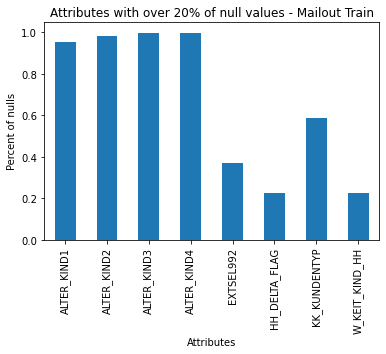

In [111]:
train_set_nulls = pd.Series(train_set.isnull().sum() / len(train_set))
ax = train_set_nulls[train_set_nulls > .2].plot(kind='bar')
ax.set_xlabel('Attributes')
ax.set_ylabel('Percent of nulls')
ax.set_title('Attributes with over 20% of null values - Mailout Train');

In [112]:
train_set['ANREDE_KZ'].value_counts(normalize=True).sort_index()

1    0.40426
2    0.59574
Name: ANREDE_KZ, dtype: float64

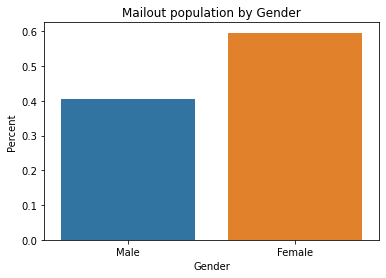

In [113]:
ax = sns.barplot(x=['Male', 'Female'], y=train_set['ANREDE_KZ'].value_counts(normalize=True).sort_index())
ax.set_xlabel('Gender')
ax.set_ylabel('Percent')
ax.set_title('Mailout population by Gender');

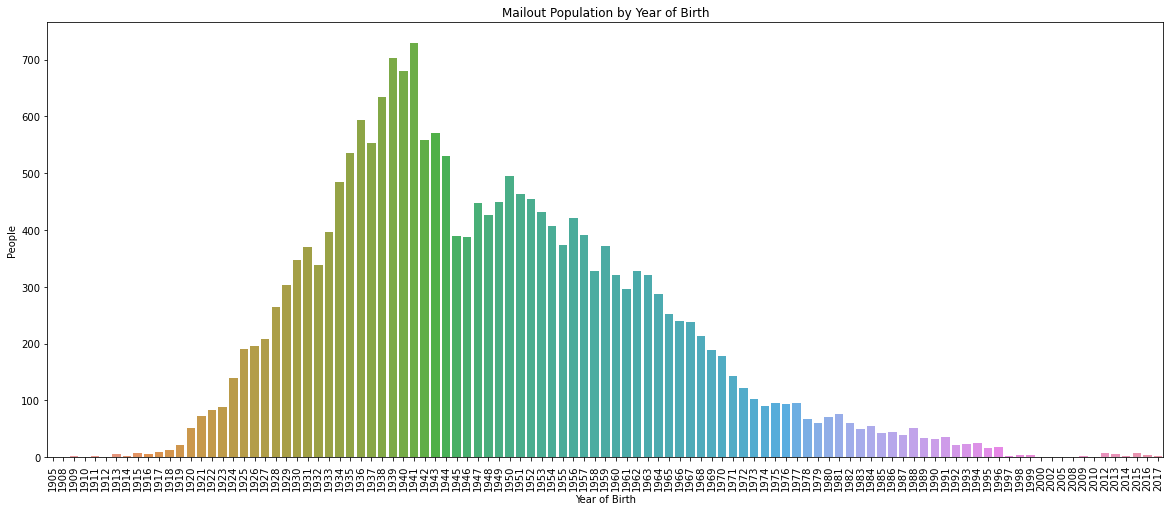

In [114]:
plt.figure(figsize=(20,8))
ax = sns.barplot(x=train_set[['GEBURTSJAHR']].query('GEBURTSJAHR != 0')['GEBURTSJAHR'].value_counts().sort_index().index, 
                 y=train_set[['GEBURTSJAHR']].query('GEBURTSJAHR != 0')['GEBURTSJAHR'].value_counts().sort_index())
plt.xticks(rotation=90)
ax.set_xlabel('Year of Birth')
ax.set_ylabel('People')
ax.set_title('Mailout Population by Year of Birth');

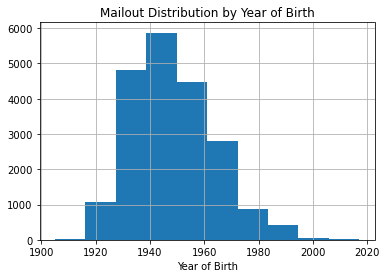

In [115]:
ax = train_set[['GEBURTSJAHR']].query('GEBURTSJAHR != 0')['GEBURTSJAHR'].hist()
ax.set_xlabel('Year of Birth')
ax.set_title('Mailout Distribution by Year of Birth');

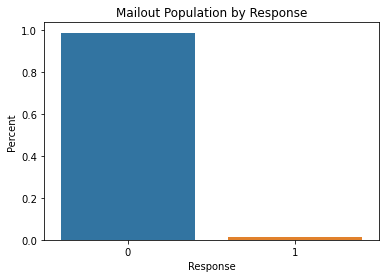

In [116]:
ax = sns.barplot(x=train_set['RESPONSE'].value_counts(normalize=True).sort_index().index, 
                 y=train_set['RESPONSE'].value_counts(normalize=True).sort_index())
ax.set_xlabel('Response')
ax.set_ylabel('Percent')
ax.set_title('Mailout Population by Response');

In [135]:
train_set['RESPONSE'].value_counts(normalize=True).sort_index()

0    0.987605
1    0.012395
Name: RESPONSE, dtype: float64

## Data Preprocessing

In [9]:
# Apply data processing steps and scaling to training data
train_df = data_prep(train_set)
scaler = StandardScaler()
y_train = train_df['RESPONSE'].values
X_train = scaler.fit_transform(train_df.drop(['RESPONSE'], axis=1))

In [10]:
# Apply data processing steps and scaling to test data
test_df = data_prep(test_set)
y_test = test_df['RESPONSE'].values
X_test = scaler.transform(test_df.drop(['RESPONSE'], axis=1))

## Implementation

### Pick a Model

In [14]:
# initialize oversampling method
adasyn = ADASYN()

In [75]:
# try out several models
models = [XGBClassifier(), GradientBoostingClassifier(), DecisionTreeClassifier(), 
          RandomForestClassifier(), LinearSVC(), SVC(), 
          LogisticRegression(), KNeighborsClassifier(), SGDClassifier(), AdaBoostClassifier()]

In [76]:
# Cross validate several models to figure out best one
for model in models:
    steps = [('adasyn', adasyn), ('model', model)]
    pipeline = Pipeline(steps=steps) # create pipeline, first oversampling, then model
    scores = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=3, n_jobs=-1)
    score = np.mean(scores)
    print(f'{model} ROC AUC score for the ADASYN sampling method: %.3f' % score)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None) ROC AUC score for the ADASYN sampling method: 0.632
GradientBoostingClassifier() ROC AUC score for the ADASYN sampling method: 0.630
DecisionTreeClassifier() ROC AUC score for the ADASYN sampling method: 0.519
RandomForestClassifier() ROC AUC score for the ADASYN sampling method: 0.590
LinearSVC() ROC AUC score f

## Refinement

### Extreme Gradient Boosting Classifier Grid Search Cross Validation

In [80]:
# Starting param grid for grid search
param_grid = {
    "model__max_depth": [3, 4, 5, 7],
    "model__learning_rate": [0.1, 0.01, 0.05],
    "model__gamma": [0, 0.25, 1],
    "model__reg_lambda": [0, 1, 10],
    "model__scale_pos_weight": [1, 3, 5],
    "model__subsample": [0.8],
    "model__colsample_bytree": [0.5],
}

xgb_cl = XGBClassifier(objective="binary:logistic")

steps = [('adasyn', adasyn), ('model', xgb_cl)]
pipeline = Pipeline(steps=steps)

grid_cv = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=3, scoring="roc_auc", verbose=3)

grid_cv.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


C:\Users\luisc\anaconda3\envs\HOML_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:29:24] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('adasyn', ADASYN()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      min_child_weigh...
                                                      scale_pos_weight=None,
                                                      subsample=None,
                                                      tree_method=None,
                                                      validate_parameters=None,
                                                      verbosity=None))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.5],
                         'model__gamma': [0, 0.25, 1],
                         'model__learning_rate': [0.1, 0.01, 0.05],
                         'model__max_depth': [3, 4, 5, 7],
                         'model__reg_lambda': [0, 1, 10],
                         'model__scale_pos_weight': [1, 3, 5],
                         'model__subsample': [0.8]},
             scoring='roc_auc', verbose=3)

In [82]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.6789195300306412
{'model__colsample_bytree': 0.5, 'model__gamma': 1, 'model__learning_rate': 0.01, 'model__max_depth': 4, 'model__reg_lambda': 1, 'model__scale_pos_weight': 1, 'model__subsample': 0.8}


In [86]:
# Fix the values in the middle
param_grid["model__scale_pos_weight"] = [1]
param_grid["model__learning_rate"] = [0.01]
param_grid["model__max_depth"] = [4]
param_grid["model__reg_lambda"] = [1]

# Expand grid for edge values
param_grid["model__gamma"] = [1, 3, 5, 7]
param_grid["model__subsample"] = [0.5, 0.7, 0.9]
param_grid["model__colsample_bytree"] = [0.5, 0.7, 0.9]

In [88]:
grid_cv2 = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=3, scoring="roc_auc", verbose=3)

grid_cv2.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\luisc\anaconda3\envs\HOML_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:50:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('adasyn', ADASYN()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      min_child_weigh...
                                                      scale_pos_weight=None,
                                                      subsample=None,
                                                      tree_method=None,
                                                      validate_parameters=None,
                                                      verbosity=None))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.5, 0.7, 0.9],
                         'model__gamma': [1, 3, 5, 7],
                         'model__learning_rate': [0.01],
                         'model__max_depth': [4], 'model__reg_lambda': [1],
                         'model__scale_pos_weight': [1],
                         'model__subsample': [0.5, 0.7, 0.9]},
             scoring='roc_auc', verbose=3)

In [90]:
print(grid_cv2.best_score_)
print(grid_cv2.best_params_)

0.6806803002636336
{'model__colsample_bytree': 0.9, 'model__gamma': 5, 'model__learning_rate': 0.01, 'model__max_depth': 4, 'model__reg_lambda': 1, 'model__scale_pos_weight': 1, 'model__subsample': 0.9}


In [91]:
# Expand grid for edge values
param_grid["model__gamma"] = [4, 5, 6]
param_grid["model__subsample"] = [0.8, 0.9, 1]
param_grid["model__colsample_bytree"] = [0.8, 0.9, 1]

In [92]:
grid_cv3 = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=3, scoring="roc_auc", verbose=3)

grid_cv3.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


C:\Users\luisc\anaconda3\envs\HOML_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:30:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('adasyn', ADASYN()),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      min_child_weigh...
                                                      reg_lambda=None,
                                                      scale_pos_weight=None,
                                                      subsample=None,
                                                      tree_method=None,
                                                      validate_parameters=None,
                                                      verbosity=None))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 0.9, 1],
                         'model__gamma': [4, 5, 6],
                         'model__learning_rate': [0.01],
                         'model__max_depth': [4], 'model__reg_lambda': [1],
                         'model__scale_pos_weight': [1],
                         'model__subsample': [0.8, 0.9, 1]},
             scoring='roc_auc', verbose=3)

In [93]:
print(grid_cv3.best_score_)
print(grid_cv3.best_params_)

0.6803455256233034
{'model__colsample_bytree': 0.8, 'model__gamma': 4, 'model__learning_rate': 0.01, 'model__max_depth': 4, 'model__reg_lambda': 1, 'model__scale_pos_weight': 1, 'model__subsample': 1}


In [97]:
# Go back to model 2 - get ROC AUC score evaluating on training data
y_scores_gb = grid_cv2.predict_proba(X_train)[:,1]
fpr_gb, tpr_gb, _ = roc_curve(y_train, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

Area under ROC curve = 0.74


In [102]:
# Count how many people should be targeted as customers
Counter(grid_cv2.predict(X_train))

Counter({0: 23783, 1: 2876})

In [123]:
# Improvement over ROC AUC Score
round(0.6806803002636336-.632, 2)

0.05

## Evaluation

In [114]:
# Evaluate on test data - Get ROC AUC score
y_scores_gb = grid_cv2.predict_proba(X_test)[:,1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

print("Area under ROC curve = {:0.2f}".format(roc_auc_gb))

Area under ROC curve = 0.74


In [115]:
# Count how many people should be targeted as customers
Counter(grid_cv2.predict(X_test))

Counter({0: 5854, 1: 750})

In [125]:
750/(5854+750)*100 # Percentage of would be customers

11.356753482737734